In [1]:
### Importing libraries and packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

# CIC-IDS 2017 DATASET

In [2]:
data = pd.read_csv('datasets/cic-ids-2017.csv')
data = data.iloc[1000000:]

In [3]:
### Checking for missing values in columns
data.isnull().sum()

Unnamed: 0                0
Destination_Port          0
Flow_Duration             0
Total_Fwd_Packets         0
Total_Backward_Packets    0
                         ..
Idle_Mean                 0
Idle_Std                  0
Idle_Max                  0
Idle_Min                  0
Label                     0
Length: 80, dtype: int64

In [4]:
### Finding Categorical Features
num_cols = data._get_numeric_data().columns
cate_cols = list(set(data.columns)-set(num_cols))
print(cate_cols)

['Label']


<Axes: xlabel='count', ylabel='Label'>

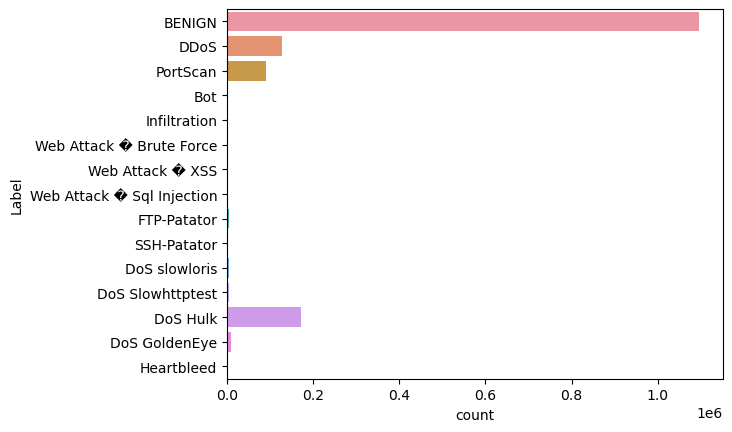

In [5]:
### Visualizing Categorical Data(Label)
#   Label - Column containing the different network attacks
sns.countplot(data = data, y='Label')

In [6]:
### Elements in Label column
def label_el(dat):
    dic = {}
    for ele in dat.Label:
        if ele not in dic: dic[ele] = 1
        else: dic[ele] += 1
    return list(dic.keys())
labels = label_el(data)

C:\Users\adeol\AppData\Local\Temp\ipykernel_14748\952724474.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna('columns')# drop columns with NaN
C:\Users\adeol\AppData\Local\Temp\ipykernel_14748\952724474.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


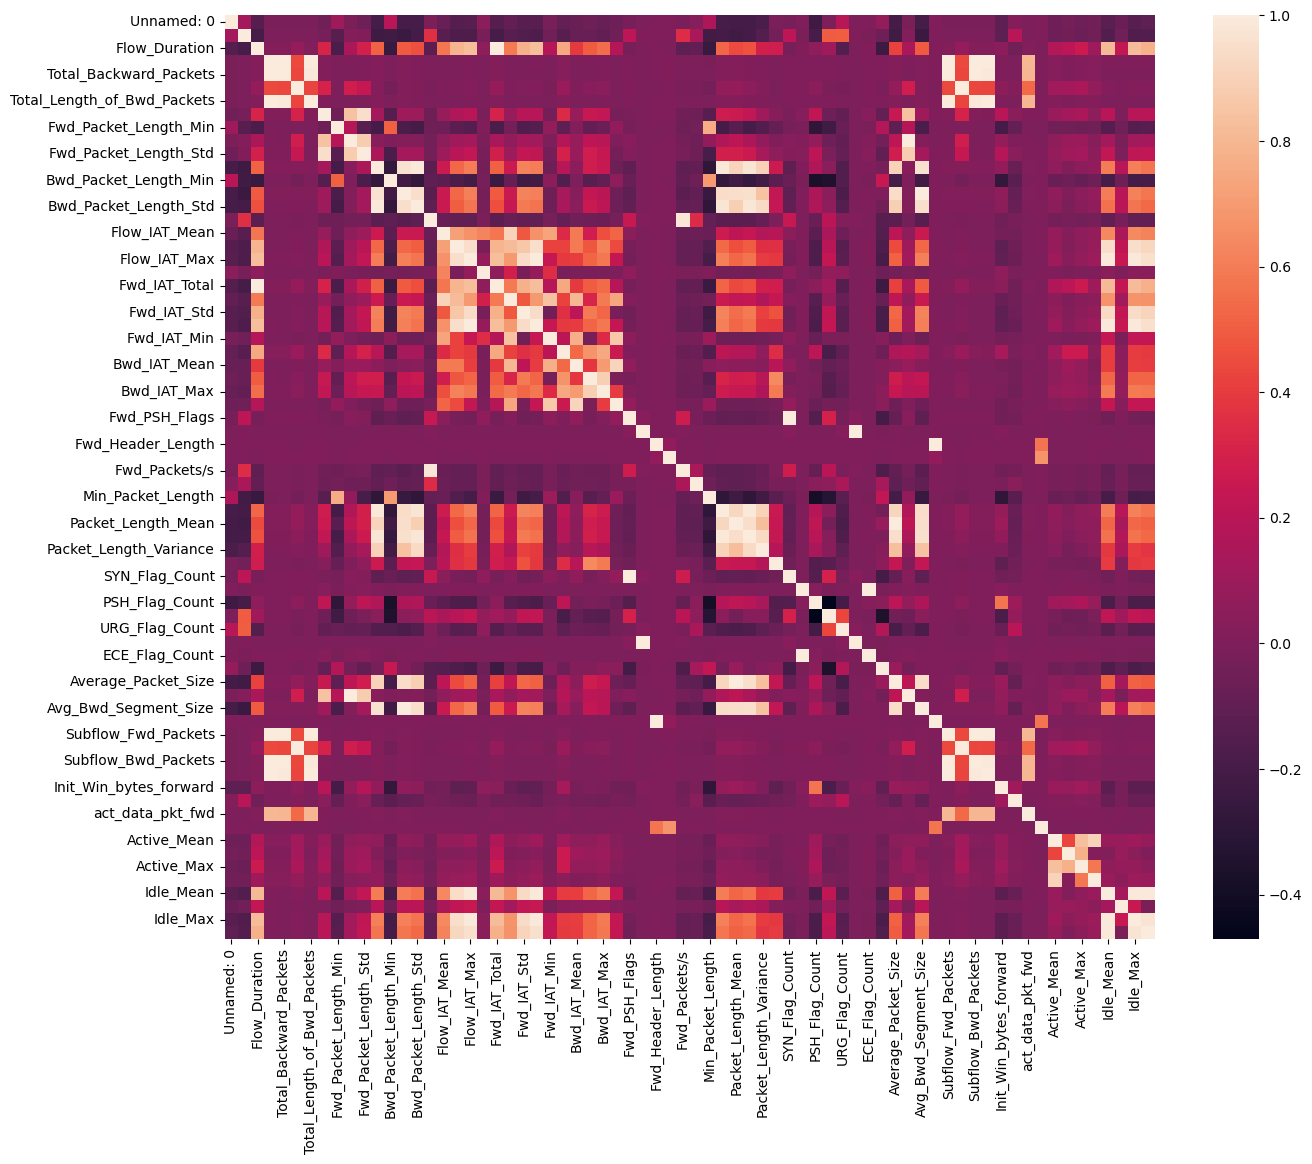

In [7]:
### Using a Heatmap to visualize correlation between features
data = data.dropna('columns')# drop columns with NaN
data = data[[col for col in data if data[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = data.corr()
plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()


In [8]:
### Dropping columns with high correlations
#   and columns with infinite values
#   Note: This only applies to CIC-IDS2017 dataset
data.drop('Fwd_Packet_Length_Max', axis = 1, inplace = True)
data.drop('Fwd_Packet_Length_Mean', axis = 1, inplace = True)
data.drop('Bwd_Packet_Length_Mean', axis = 1, inplace = True)
data.drop('Subflow_Bwd_Bytes', axis = 1, inplace = True)
data.drop('Bwd_Packet_Length_Max', axis = 1, inplace = True)
data.drop('Flow_Packets/s', axis = 1, inplace = True)

In [9]:
### Feature Mapping on Labels Categorical Data
lmap = {}
i = 0
for ele in data.Label:
    if ele not in lmap:
        lmap[ele] = i
        i += 1
data['Label'] = data['Label'].map(lmap)

In [10]:
### Scaling Dataset for Training and Testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Splitting the dataset
print(data.shape)
# Target variable and train set
y = data[['Label']]
X = data.drop(['Label', ], axis = 1)
sc = MinMaxScaler()
X = sc.fit_transform(X,y)

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1522362, 65)
(1019982, 64) (502380, 64)
(1019982, 1) (502380, 1)


In [11]:
### Using PCA for Feature Selection and Dimensional Transformation
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
### Random Forest Model
from sklearn.ensemble import RandomForestClassifier

clfr = RandomForestClassifier(n_estimators = 30)
start_time = time.time()
clfr.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_rf = clfr.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_rf = clfr.score(X_train_pca, y_train)
test_score_rf = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_rf)
print("Test score is:", test_score_rf)

Training time:  409.2318048477173
Testing time:  7.800893545150757
Train score is: 0.9999549011649225
Test score is: 0.9938492774393886


In [ ]:
### Support Vector Machine Model
# from sklearn.svm import SVC

# clfs = SVC(gamma = 'scale')
# start_time = time.time()
# clfs.fit(X_train_pca, y_train.values.ravel())
# end_time = time.time()
# print("Training time: ", end_time-start_time)

# start_time = time.time()
# y_pred_svm = clfs.predict(X_test_pca)
# end_time = time.time()
# print("Testing time: ", end_time-start_time)

# train_score_svm = clfr.score(X_train_pca, y_train)
# test_score_svm = clfr.score(X_test_pca, y_test)
# print("Train score is:", train_score_svm)
# print("Test score is:", test_score_svm)

In [13]:
### Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_tree = clfd.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_tree = clfr.score(X_train_pca, y_train)
test_score_tree = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_tree)
print("Test score is:", test_score_tree)

Training time:  57.52174091339111
Testing time:  0.14180755615234375
Train score is: 0.9999549011649225
Test score is: 0.9938492774393886


In [14]:
### K-Nearest Neighbors Model
from sklearn.neighbors import KNeighborsClassifier
clfk = KNeighborsClassifier(n_neighbors=3)
start_time = time.time()
clfk.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_knn = clfk.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_knn = clfr.score(X_train_pca, y_train)
test_score_knn = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_knn)
print("Test score is:", test_score_knn)

Training time:  8.079700708389282
Testing time:  50.53793549537659
Train score is: 0.9999549011649225
Test score is: 0.9938492774393886


In [15]:
### Confusion Matrix on Machine Learning Models
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Random Forest
confusion_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix (random forest):\n{}".format(confusion_rf))
# Confusion Matrix for Support Vector Machine
# confusion = confusion_matrix(y_test, y_pred_svm)
# print("Confusion matrix (svm):\n{}".format(confusion))
# Confusion Matrix for Decision Tree
confusion_tree = confusion_matrix(y_test, y_pred_tree)
print("Confusion matrix (decision tree):\n{}".format(confusion_tree))
# Confusion Matrix for K Nearest Neighbor
confusion = confusion_matrix(y_test, y_pred_knn)
print("Confusion matrix (knn):\n{}".format(confusion))

Confusion matrix (random forest):
[[360154     67   1014      9      0     58     18      0      0      5
       4      5    104      8      0]
 [    57  42032      0      0      0      0      0      0      0      0
       0      0    142      0      0]
 [  1085      0  28938      0      0      0      0      0      0      0
       0      0      6      0      0]
 [    37      0      0    601      0      0      0      0      0      0
       0      0      0      0      0]
 [     9      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [    64      0      0      0      0    426      0      0      0      0
       0      0      0      0      0]
 [    12      0      0      0      0      0    214      0      0      0
       0      0      0      0      0]
 [     7      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     9      0      0      0      0      0      0      0   1974      0
       1      

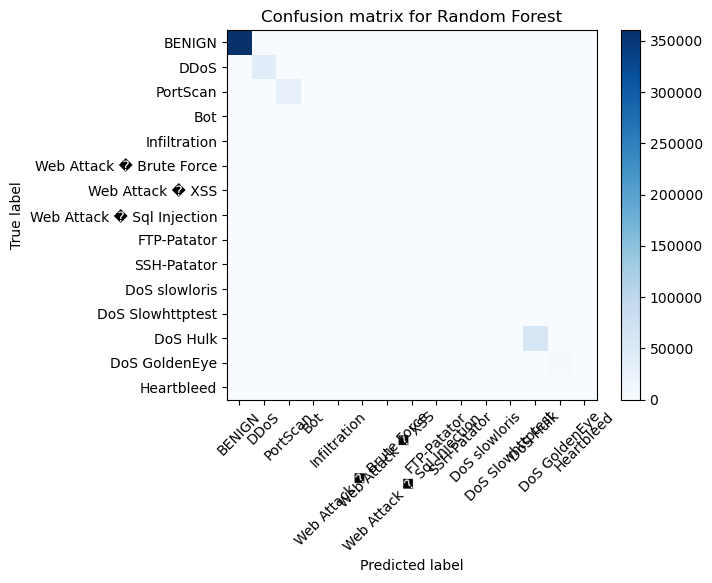

In [16]:
### Visualization of Confusion Matrix for Random Forest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for Random Forest
y_pred_rf = clfr.predict(X_test_pca)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix for Random Forest
plt.imshow(cm_rf, cmap='Blues')
plt.title('Confusion matrix for Random Forest')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

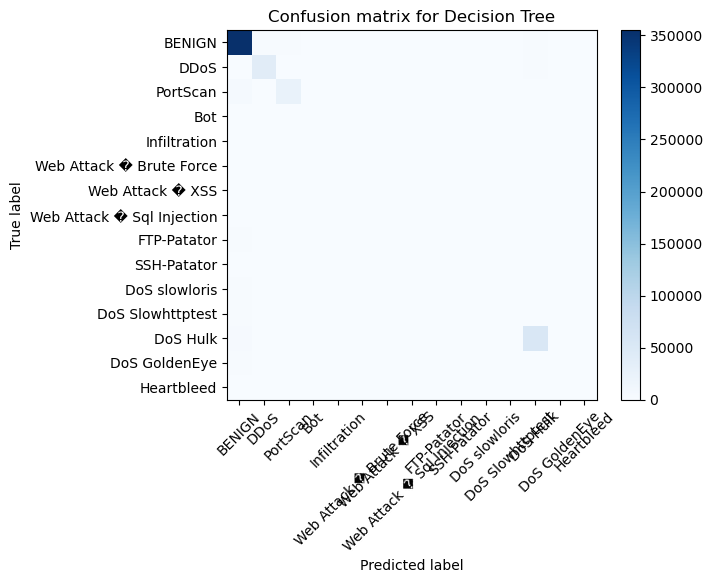

In [17]:
### Visualization of Confusion Matrix for Decision Tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for Decision Tree
y_pred_tree = clfd.predict(X_test_pca)
cm_dt = confusion_matrix(y_test, y_pred_tree)

# Plot the confusion matrix for Decision Tree
plt.imshow(cm_dt, cmap='Blues')
plt.title('Confusion matrix for Decision Tree')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

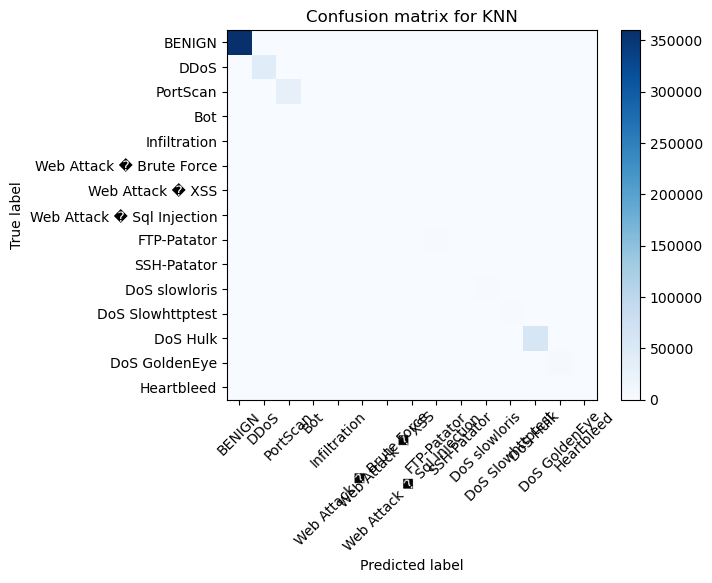

In [18]:
### Visualization of Confusion Matrix for KNN
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for KNN
y_pred_knn = clfk.predict(X_test_pca)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix for KNN
plt.imshow(cm_knn, cmap='Blues')
plt.title('Confusion matrix for KNN')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [19]:
### F1 Score Evaluation on Machine Learning Models
from sklearn.metrics import f1_score
f1_score_rf = f1_score(y_test, y_pred_rf, average = 'weighted')
# f1_score_svm = f1_score(y_test, y_pred_svm, average = 'weighted')
f1_score_tree = f1_score(y_test, y_pred_tree, average = 'weighted')
f1_score_knn = f1_score(y_test, y_pred_knn, average = 'weighted')

print("f1 score random forest: {:.2f}".format(f1_score_rf))
# print("f1 score svm: {:.2f}".format(f1_score_svm))
print("f1 score decision tree: {:.2f}".format(f1_score_tree))
print("f1 score knn: {:.2f}".format(f1_score_knn))

f1 score random forest: 0.99
f1 score decision tree: 0.93
f1 score knn: 0.99


In [20]:
### Recall Evaluation on Machine Learning Models
from sklearn.metrics import recall_score
recall_score_rf = recall_score(y_test, y_pred_rf, average = 'weighted')
# recall_score_svm = recall_score(y_test, y_pred_svm, average = 'weighted')
recall_score_tree = recall_score(y_test, y_pred_tree, average = 'weighted')
recall_score_knn = recall_score(y_test, y_pred_knn, average = 'weighted')

print("recall score random forest: {:.2f}".format(recall_score_rf))
# print("recall score svm: {:.2f}".format(recall_score_svm))
print("recall score decision tree: {:.2f}".format(recall_score_tree))
print("recall score knn: {:.2f}".format(recall_score_knn))

recall score random forest: 0.99
recall score decision tree: 0.94
recall score knn: 0.99


In [21]:
### Precision Evaluation on Machine Learning Models
from sklearn.metrics import precision_score
precision_score_rf = precision_score(y_test, y_pred_rf, average = 'weighted')
# precision_score_svm = precision_score(y_test, y_pred_svm, average = 'weighted')
precision_score_tree = precision_score(y_test, y_pred_tree, average = 'weighted')
precision_score_knn = precision_score(y_test, y_pred_knn, average = 'weighted')

print("precision score random forest: {:.2f}".format(precision_score_rf))
# print("precision score svm: {:.2f}".format(precision_score_svm))
print("precision score decision tree: {:.2f}".format(precision_score_tree))
print("precision score knn: {:.2f}".format(precision_score_knn))

C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score random forest: 0.99
precision score decision tree: 0.92
precision score knn: 0.99


Text(0, 0.5, 'Percentage')

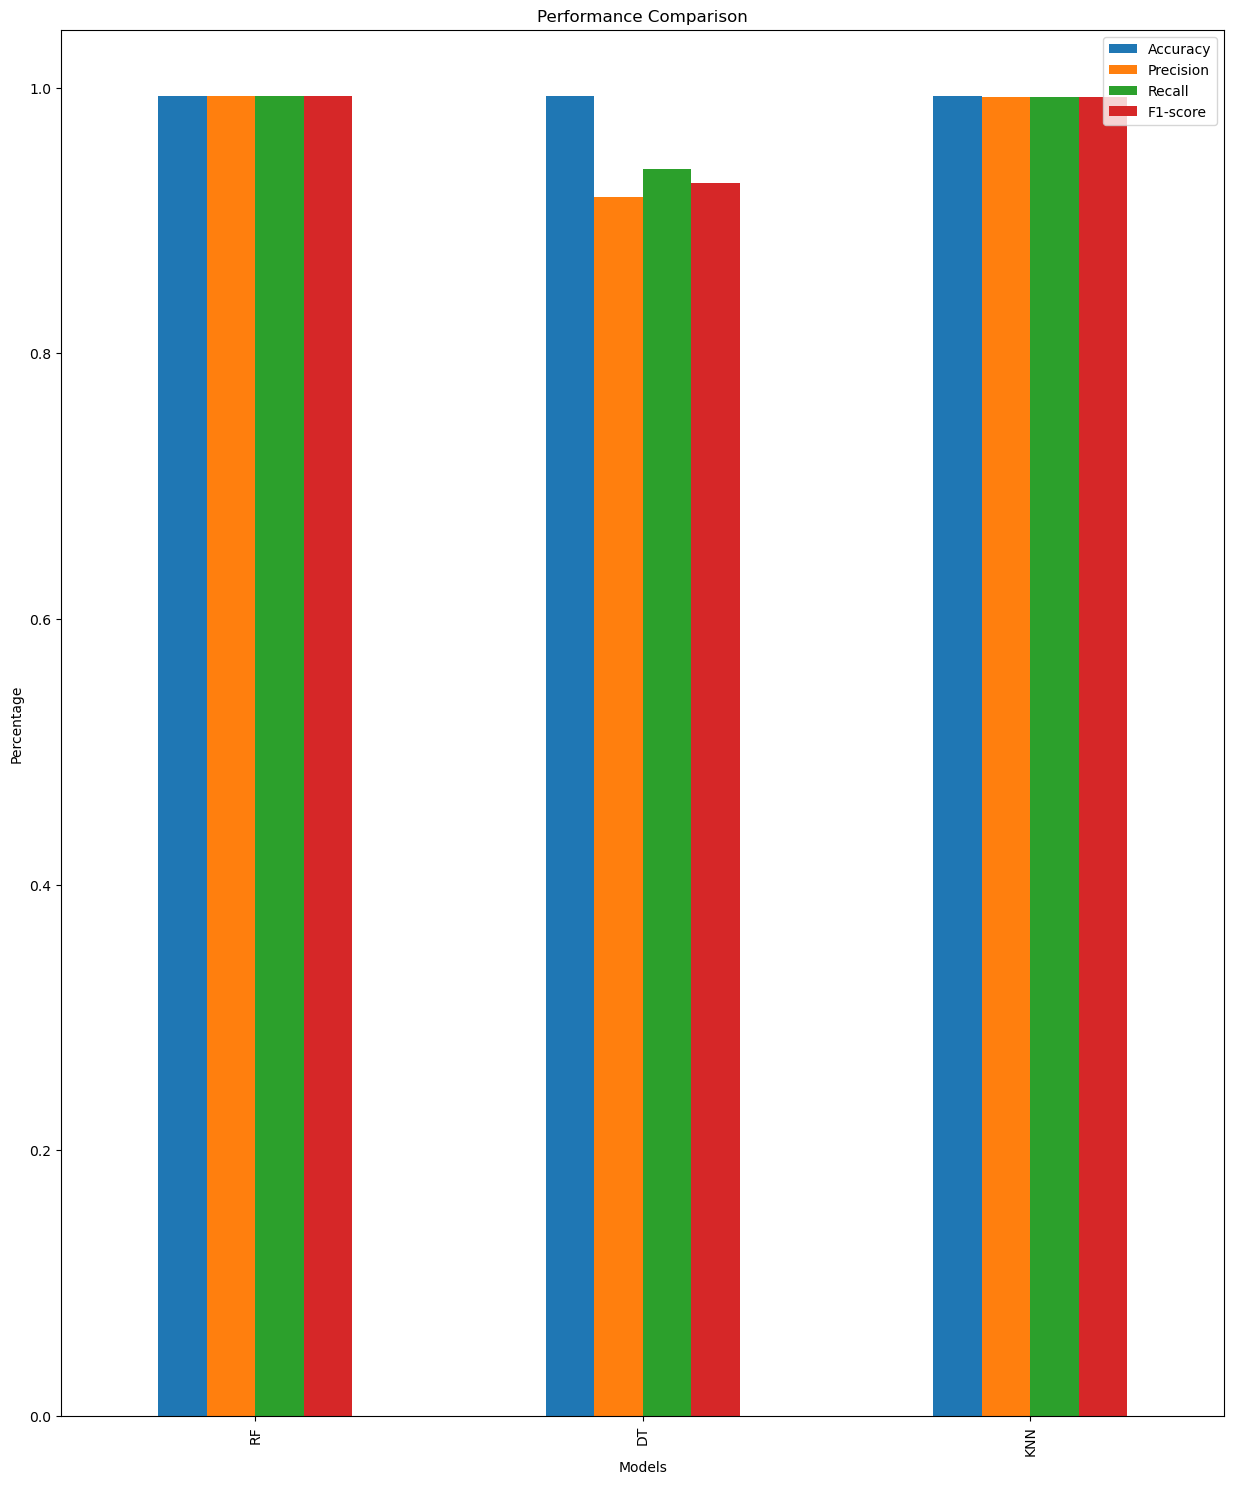

In [22]:
### Performance Evaluation of Models
plotdata = pd.DataFrame({
    'Accuracy': [test_score_rf,test_score_tree,test_score_knn],
    'Precision': [precision_score_rf,precision_score_tree,precision_score_knn],
    'Recall': [recall_score_rf,recall_score_tree,recall_score_knn],
    'F1-score': [f1_score_rf,f1_score_tree,f1_score_knn]},
    index= ['RF','DT','KNN'])
plotdata.plot(kind= 'bar', figsize= (15,18))
plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Percentage')

In [23]:
from sklearn.metrics import classification_report
print('Classification Report (Random Forest):\n',classification_report(y_test, y_pred_rf, target_names=labels))
# print('Classificstion Report (Support Vector Machine):\n',classification_report(y_test, y_pred_svm, target_names=labels))
print('Classification Report (Decision Tree):\n',classification_report(y_test, y_pred_tree, target_names=labels))
print('Classificstion Report (K Nearest Neighbor):\n',classification_report(y_test, y_pred_knn, target_names=labels))

C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report (Random Forest):
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    361446
                      DDoS       1.00      1.00      1.00     42231
                  PortScan       0.97      0.96      0.96     30029
                       Bot       0.99      0.94      0.96       638
              Infiltration       0.00      0.00      0.00         9
  Web Attack � Brute Force       0.88      0.87      0.87       490
          Web Attack � XSS       0.91      0.95      0.93       226
Web Attack � Sql Injection       0.00      0.00      0.00         7
               FTP-Patator       1.00      0.99      1.00      1984
               SSH-Patator       0.99      0.95      0.97      1030
             DoS slowloris       1.00      0.99      0.99      1759
          DoS Slowhttptest       1.00      0.99      0.99      1724
                  DoS Hulk       1.00      1.00      1.00     57308
       

C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report (Decision Tree):
                             precision    recall  f1-score   support

                    BENIGN       0.95      0.98      0.96    361446
                      DDoS       0.90      0.93      0.91     42231
                  PortScan       0.89      0.82      0.85     30029
                       Bot       0.00      0.00      0.00       638
              Infiltration       0.00      0.00      0.00         9
  Web Attack � Brute Force       0.00      0.00      0.00       490
          Web Attack � XSS       0.00      0.00      0.00       226
Web Attack � Sql Injection       0.00      0.00      0.00         7
               FTP-Patator       0.00      0.00      0.00      1984
               SSH-Patator       0.00      0.00      0.00      1030
             DoS slowloris       0.00      0.00      0.00      1759
          DoS Slowhttptest       0.00      0.00      0.00      1724
                  DoS Hulk       0.94      0.92      0.93     57308
       

# CSE-CIC-IDS 2018

In [2]:
data = pd.read_csv('datasets/cse-cic-ids-2018.csv')
#data = data.iloc[1000000:]

C:\Users\adeol\AppData\Local\Temp\ipykernel_6772\2163644799.py:1: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('datasets/cse-cic-ids-2018.csv')


In [3]:
# Dropping all strings columns 
data = data.loc[data['Label'] != 'Label']

In [4]:
### Elements in Label column
def label_el(dat):
    dic = {}
    for ele in dat.Label:
        if ele not in dic: dic[ele] = 1
        else: dic[ele] += 1
    return list(dic.keys())
labels = label_el(data)

<Axes: xlabel='count', ylabel='Label'>

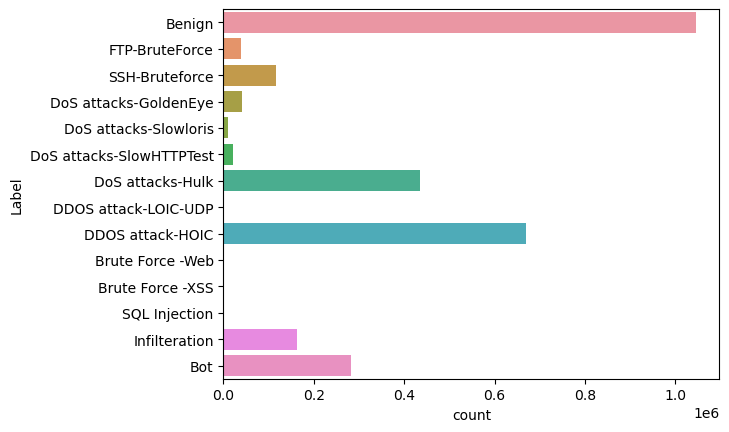

In [5]:
### Visualizing Categorical Data(Label)
#   Label - Column containing the different network attacks
# sns.countplot(data["Label"])
sns.countplot(data = data, y = 'Label')

In [6]:
labels

['Benign',
 'FTP-BruteForce',
 'SSH-Bruteforce',
 'DoS attacks-GoldenEye',
 'DoS attacks-Slowloris',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Hulk',
 'DDOS attack-LOIC-UDP',
 'DDOS attack-HOIC',
 'Brute Force -Web',
 'Brute Force -XSS',
 'SQL Injection',
 'Infilteration',
 'Bot']

C:\Users\adeol\AppData\Local\Temp\ipykernel_6772\4212945276.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna('columns')# drop columns with NaN
C:\Users\adeol\AppData\Local\Temp\ipykernel_6772\4212945276.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


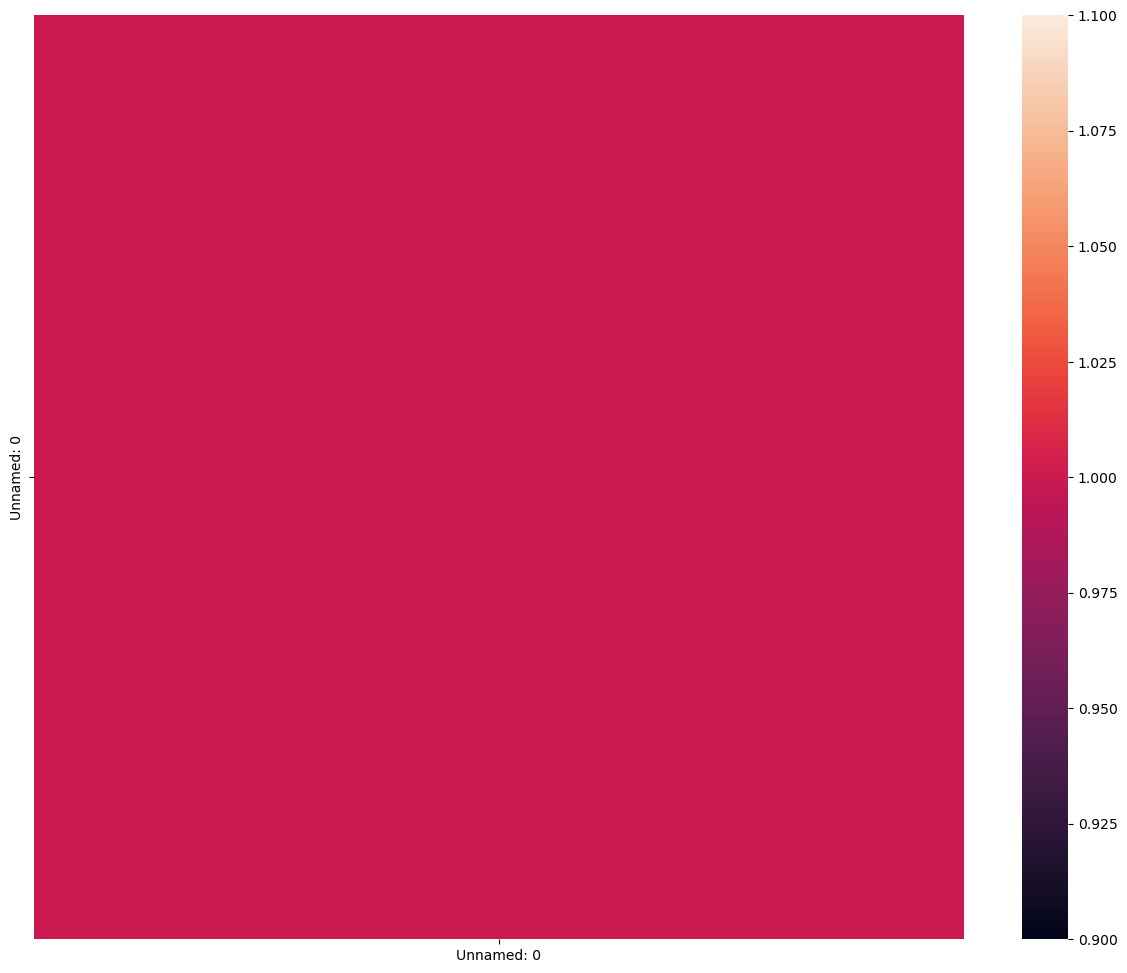

In [8]:
### Using a Heatmap to visualize correlation between features
data = data.dropna('columns')# drop columns with NaN
data = data[[col for col in data if data[col].nunique() > 1]]# keep columns where there are more than 1 unique values


corr = data.corr()
plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()


In [9]:
### Dropping columns with high correlations
#   and columns with infinite values
#   Note: This only applies to CSE-CIC-IDS2018 dataset
data.drop('Flow_IAT_Min', axis = 1, inplace = True)
data.drop('Flow_IAT_Mean', axis = 1, inplace = True)
data.drop('Flow_IAT_Max', axis = 1, inplace = True)
data.drop('Flow_IAT_Std', axis = 1, inplace = True)
data.drop('Idle_Mean', axis = 1, inplace = True)
data.drop('Idle_Max', axis = 1, inplace = True)
data.drop('Flow_Pkts/s', axis = 1, inplace = True)
data.drop('Timestamp', axis = 1, inplace = True)

In [10]:
### Feature Mapping on Labels Categorical Data
lmap = {}
i = 0
for ele in data.Label:
    if ele not in lmap:
        lmap[ele] = i
        i += 1
data['Label'] = data['Label'].map(lmap)

In [11]:
### Scaling Dataset for Training and Testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Splitting the dataset
print(data.shape)
# Target variable and train set
y = data[['Label']]
X = data.drop(['Label', ], axis = 1)
sc = MinMaxScaler()
X = sc.fit_transform(X,y)

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2824651, 72)
(1892516, 71) (932135, 71)
(1892516, 1) (932135, 1)


In [12]:
### Using PCA for Feature Selection and Dimensional Transformation
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
### Random Forest Model
from sklearn.ensemble import RandomForestClassifier

clfr = RandomForestClassifier(n_estimators = 30)
start_time = time.time()
clfr.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_rf = clfr.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_rf = clfr.score(X_train_pca, y_train)
test_score_rf = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_rf)
print("Test score is:", test_score_rf)

Training time:  1108.2828557491302
Testing time:  14.4896821975708
Train score is: 0.9995899638365012
Test score is: 0.9767029453888117


In [ ]:
### Support Vector Machine Model
# from sklearn.svm import SVC

# clfs = SVC(gamma = 'scale')
# start_time = time.time()
# clfs.fit(X_train_pca, y_train.values.ravel())
# end_time = time.time()
# print("Training time: ", end_time-start_time)

# start_time = time.time()
# y_pred_svm = clfs.predict(X_test_pca)
# end_time = time.time()
# print("Testing time: ", end_time-start_time)

# train_score_svm = clfr.score(X_train_pca, y_train)
# test_score_svm = clfr.score(X_test_pca, y_test)
# print("Train score is:", train_score_svm)
# print("Test score is:", test_score_svm)

In [14]:
### Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_tree = clfd.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_tree = clfr.score(X_train_pca, y_train)
test_score_tree = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_tree)
print("Test score is:", test_score_tree)

Training time:  80.90391731262207
Testing time:  0.4116530418395996
Train score is: 0.9995899638365012
Test score is: 0.9767029453888117


In [15]:
### K-Nearest Neighbors Model
from sklearn.neighbors import KNeighborsClassifier
clfk = KNeighborsClassifier(n_neighbors=3)
start_time = time.time()
clfk.fit(X_train_pca, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_pred_knn = clfk.predict(X_test_pca)
end_time = time.time()
print("Testing time: ", end_time-start_time)

train_score_knn = clfr.score(X_train_pca, y_train)
test_score_knn = clfr.score(X_test_pca, y_test)
print("Train score is:", train_score_knn)
print("Test score is:", test_score_knn)

Training time:  17.477736711502075
Testing time:  86.55474090576172
Train score is: 0.9995899638365012
Test score is: 0.9767029453888117


In [16]:
### Confusion Matrix on Machine Learning Models
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Random Forest
confusion_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix (random forest):\n{}".format(confusion_rf))
# Confusion Matrix for Support Vector Machine
# confusion = confusion_matrix(y_test, y_pred_svm)
# print("Confusion matrix (svm):\n{}".format(confusion))
# Confusion Matrix for Decision Tree
confusion_tree = confusion_matrix(y_test, y_pred_tree)
print("Confusion matrix (decision tree):\n{}".format(confusion_tree))
# Confusion Matrix for K Nearest Neighbor
confusion = confusion_matrix(y_test, y_pred_knn)
print("Confusion matrix (knn):\n{}".format(confusion))

Confusion matrix (random forest):
[[338495      0      0      0      0      1      2      0      2     16
       1      0   6027     58]
 [     0   9833      1      0      0   3080      0      0      0      0
       0      0      0      0]
 [     0      2  38780      0      0      0      2      0      0      0
       0      0      0      0]
 [     0      0      0  13715      0      0      0      0      0      0
       0      0      0      0]
 [     1      0      0      0   3330      0      0      0      0      0
       0      0      0      0]
 [     0   3177      0      0      0   3805      0      0      0      0
       0      0      0      0]
 [     0      0      0      0      0      0 143155      0      0      0
       0      0      0      0]
 [     0      0      0      0      0      0      0    580      0      0
       0      0      0      0]
 [     1      0      0      0      0      0      0      0 221201      0
       0      0      0      0]
 [    38      0      0      0      0   

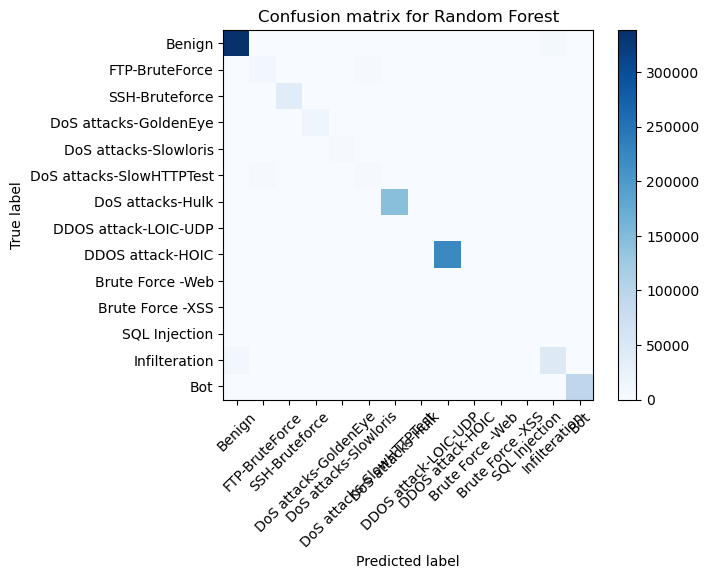

In [17]:
### Visualization of Confusion Matrix for Respective Models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for Random Forest
y_pred_rf = clfr.predict(X_test_pca)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix for Random Forest
plt.imshow(cm_rf, cmap='Blues')
plt.title('Confusion matrix for Random Forest')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

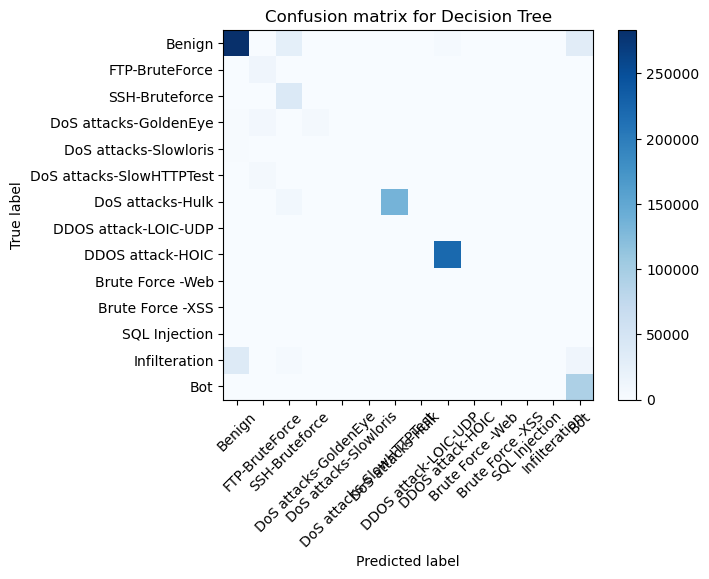

In [18]:
### Visualization of Confusion Matrix for Respective Models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for Decision Tree
y_pred_tree = clfd.predict(X_test_pca)
cm_dt = confusion_matrix(y_test, y_pred_tree)

# Plot the confusion matrix for Decision Tree
plt.imshow(cm_dt, cmap='Blues')
plt.title('Confusion matrix for Decision Tree')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

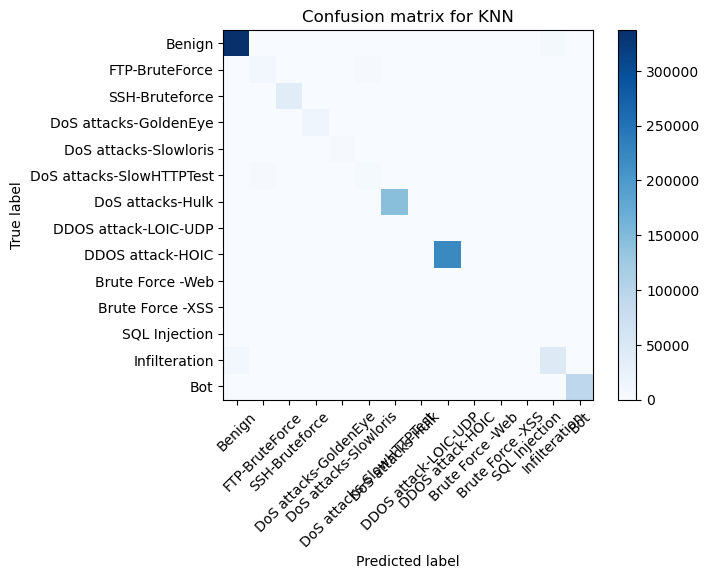

In [19]:
### Visualization of Confusion Matrix for Respective Models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix for KNN
y_pred_knn = clfk.predict(X_test_pca)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix for KNN
plt.imshow(cm_knn, cmap='Blues')
plt.title('Confusion matrix for KNN')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [20]:
### F1 Score Evaluation on Machine Learning Models
from sklearn.metrics import f1_score
f1_score_rf = f1_score(y_test, y_pred_rf, average = 'weighted')
# f1_score_svm = f1_score(y_test, y_pred_svm, average = 'weighted')
f1_score_tree = f1_score(y_test, y_pred_tree, average = 'weighted')
f1_score_knn = f1_score(y_test, y_pred_knn, average = 'weighted')

print("f1 score random forest: {:.2f}".format(f1_score_rf))
# print("f1 score svm: {:.2f}".format(f1_score_svm))
print("f1 score decision tree: {:.2f}".format(f1_score_tree))
print("f1 score knn: {:.2f}".format(f1_score_knn))

f1 score random forest: 0.98
f1 score decision tree: 0.82
f1 score knn: 0.98


In [21]:
### Recall Evaluation on Machine Learning Models
from sklearn.metrics import recall_score
recall_score_rf = recall_score(y_test, y_pred_rf, average = 'weighted')
# recall_score_svm = recall_score(y_test, y_pred_svm, average = 'weighted')
recall_score_tree = recall_score(y_test, y_pred_tree, average = 'weighted')
recall_score_knn = recall_score(y_test, y_pred_knn, average = 'weighted')

print("recall score random forest: {:.2f}".format(recall_score_rf))
# print("recall score svm: {:.2f}".format(recall_score_svm))
print("recall score decision tree: {:.2f}".format(recall_score_tree))
print("recall score knn: {:.2f}".format(recall_score_knn))

recall score random forest: 0.98
recall score decision tree: 0.84
recall score knn: 0.98


In [22]:
### Precision Evaluation on Machine Learning Models
from sklearn.metrics import precision_score
precision_score_rf = precision_score(y_test, y_pred_rf, average = 'weighted')
# precision_score_svm = precision_score(y_test, y_pred_svm, average = 'weighted')
precision_score_tree = precision_score(y_test, y_pred_tree, average = 'weighted')
precision_score_knn = precision_score(y_test, y_pred_knn, average = 'weighted')

print("precision score random forest: {:.2f}".format(precision_score_rf))
# print("precision score svm: {:.2f}".format(precision_score_svm))
print("precision score decision tree: {:.2f}".format(precision_score_tree))
print("precision score knn: {:.2f}".format(precision_score_knn))

C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score random forest: 0.98
precision score decision tree: 0.87
precision score knn: 0.98


Text(0, 0.5, 'Percentage')

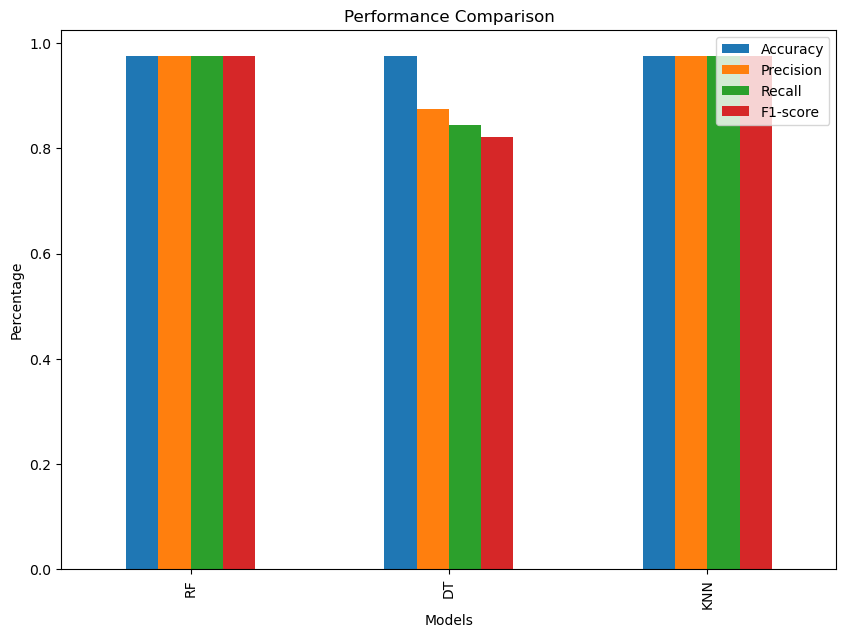

In [32]:
### Performance Evaluation of Models
plotdata = pd.DataFrame({
    'Accuracy': [test_score_rf,test_score_tree,test_score_knn],
    'Precision': [precision_score_rf,precision_score_tree,precision_score_knn],
    'Recall': [recall_score_rf,recall_score_tree,recall_score_knn],
    'F1-score': [f1_score_rf,f1_score_tree,f1_score_knn]},
    index= ['RF','DT','KNN'])
plotdata.plot(kind= 'bar', figsize= (10,7))
plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Percentage')

In [24]:
from sklearn.metrics import classification_report
print('Classification Report (Random Forest):\n',classification_report(y_test, y_pred_rf, target_names=labels))
# print('Classificstion Report (Support Vector Machine):\n',classification_report(y_test, y_pred_svm, target_names=labels))
print('Classification Report (Decision Tree):\n',classification_report(y_test, y_pred_tree, target_names=labels))
print('Classificstion Report (K Nearest Neighbor):\n',classification_report(y_test, y_pred_knn, target_names=labels))

Classification Report (Random Forest):
                           precision    recall  f1-score   support

                  Benign       0.97      0.98      0.98    344602
          FTP-BruteForce       0.76      0.76      0.76     12914
          SSH-Bruteforce       1.00      1.00      1.00     38784
   DoS attacks-GoldenEye       1.00      1.00      1.00     13715
   DoS attacks-Slowloris       1.00      1.00      1.00      3331
DoS attacks-SlowHTTPTest       0.55      0.54      0.55      6982
        DoS attacks-Hulk       1.00      1.00      1.00    143155
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       580
        DDOS attack-HOIC       1.00      1.00      1.00    221202
        Brute Force -Web       0.90      0.81      0.85       211
        Brute Force -XSS       0.99      0.95      0.97        80
           SQL Injection       0.87      0.87      0.87        23
           Infilteration       0.88      0.83      0.85     53304
                     Bot       1.00

C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adeol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report (Decision Tree):
                           precision    recall  f1-score   support

                  Benign       0.87      0.82      0.85    344602
          FTP-BruteForce       0.44      0.92      0.60     12914
          SSH-Bruteforce       0.50      1.00      0.67     38784
   DoS attacks-GoldenEye       1.00      0.33      0.49     13715
   DoS attacks-Slowloris       0.00      0.00      0.00      3331
DoS attacks-SlowHTTPTest       0.00      0.00      0.00      6982
        DoS attacks-Hulk       1.00      0.94      0.97    143155
    DDOS attack-LOIC-UDP       0.00      0.00      0.00       580
        DDOS attack-HOIC       0.98      1.00      0.99    221202
        Brute Force -Web       0.00      0.00      0.00       211
        Brute Force -XSS       0.00      0.00      0.00        80
           SQL Injection       0.00      0.00      0.00        23
           Infilteration       0.99      0.00      0.01     53304
                     Bot       0.68

In [ ]:
### --- EXTRACTION POINT --- ###

In [ ]:
pd.set_option('display.max_rows', 9999)

In [ ]:
#   Cleaning Data
colms = {col: np.float64 for col in data.columns}
print('colms created')
del colms['Timestamp']
del colms['Label']
print('deleted objects')
data = data.loc[data['Label'] != 'Label']
print('removed string from Dst')
data = data.astype(dtype = colms)
print('converted dtypes to float')

In [ ]:
class Prep:
    def __init__(self, dataset, new_wh_b, new_wh_a):
        self.data = pd.read_csv(dataset)
        self.new_wh_b = new_wh_b
        self.new_wh_a = new_wh_a
        self.benign_key = ''

    def head(self):
        #print('Formatting headers...')
        old_data = [header for header in self.data.columns]
        new_data = []
        for header in self.data.columns:
            header = re.sub(r'^\s','',header)
            header = re.sub(r'\s+','_',header)
            new_data.append(header)
        dic = dict(zip(old_data,new_data))
        self.data.rename(columns= dic, inplace= True)
        #print('Formatting headers: Done')

    def benign(self):
        #print('Getting Benign key...')
        for ele in self.data.Label:
            if ele == 'BENIGN' or ele == 'Benign':
                self.benign_key = ele
                #print('Getting Benign key: Done')
                return 0    

    def new_ds_b(self):
        #print('Creating new benign dataset...')
        self.new_wh_b = self.new_wh_b.append(self.data.loc[self.data['Label']== self.benign_key])
        return self.new_wh_b

    def new_ds_a(self):
        #print('Creating new attack dataset...')
        self.new_wh_a = self.new_wh_a.append(self.data.loc[self.data['Label'] != self.benign_key])
        return self.new_wh_a

In [ ]:
data = data.loc[data['Label'] != 'Label']

In [ ]:
datasets = ['datasets/2018/'+ path for path in os.listdir('datasets/2018/')]

wh_b = wh_a = pd.DataFrame([])
for dts in datasets:
    p = Prep(dts, wh_b, wh_a)
    p.head()
    p.benign()
    #wh_b = p.new_ds_b()
    wh_a = p.new_ds_a()
    print('Done')
'''
data = wh_b.append(wh_a)
data.to_csv('datasets/cic-ids-2017.csv')
#data = data.iloc[1000000:]
'''
print(wh_a.shape)

In [ ]:
p = Prep(r"datasets\2018\dated_ds_0222.csv", pd.DataFrame([]), pd.DataFrame([]))
p.head()
p.benign()
wh_b = p.new_ds_b()
#wh_a = p.new_ds_a()
print(wh_b.shape)

In [ ]:
data = wh_b.append(wh_a)
data.shape

In [ ]:
bool_series = data.duplicated(keep= 'first')
data = data[~bool_series]

In [ ]:
data.shape

In [ ]:
data.to_csv('datasets/cse-cic-ids-2018.csv')

In [ ]:
 bool_series = self.new_wh_b.duplicated(keep= 'first')
        self.new_wh_b = self.new_wh_b[~bool_series]
        #print('Creating new benign dataset: Done')
 #print(self.new_wh_a.shape)
        bool_series = self.new_wh_a.duplicated(keep= 'first')
        self.new_wh_a = self.new_wh_a[~bool_series]
        #print('Creating new attack dataset: Done')
        

In [ ]:
plotdata = pd.DataFrame({
    'Accuracy': [93,96,91,92],
    'Precision': [92,94,89,91],
    'Recall': [93,95,92,90],
    'F1-score': [90,91,92,93]},
    index= ['RF','DT','SVM','KNN'])
plotdata.plot(kind= 'bar', figsize= (15,18))
plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Percentage')